A notebook which contains timeseries of SalishSeaCast model output and observed data within PugetSound. This script is designed so that changes the the observed and model data over time can be easily compared.

In [41]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')
import warnings
warnings.filterwarnings('ignore')

In [42]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
from scipy import optimize as opt
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
import Keegan_eval_tools as ket
from salishsea_tools import evaltools as et, viz_tools
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [43]:
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
saveloc='/ocean/kflanaga/MEOPAR/savedData'

In [44]:
# Parameters
year = 2018
modver = "nowcast-green.201905"
PATH = "/results2/SalishSea/nowcast-green.201905/"
saveloc = "/ocean/kflanaga/MEOPAR/savedData"


In [45]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2018

In [46]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [47]:
##### Loading in pickle file data
with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)
    
with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{year}.pkl'),'rb') as hh:
    data_Pheo=pickle.load(hh)

In [48]:
def TsByDepth(df,obsvar,modvar,year,title,units='($\mu$M)'):
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    ps=et.tsertser_graph(ax,df,obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
    ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    ax.set_xlabel(f'Date',fontsize=20)
    ax.set_ylabel(f'{obsvar} {units}',fontsize=20)
    ax.set_title(f'{title}', fontsize=22)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    return ax
    
def ts_error_trendline(ax,df,obsvar,modvar,start_date,end_date):
    ps=list()
    df=df.sort_values(by='dtUTC').dropna()
    yd=list()
    timepy=df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date)].dtUTC.dt.to_pydatetime()
    obs0=et._deframe(df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[obsvar]])
    mod0=et._deframe(df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[modvar]])
    time0=et._deframe(timepy)
    for i in time0:
        yd.append((i - dt.datetime(i.year, 1, 1)).days + 1)
    coefse = poly.polyfit(yd,mod0-obs0,4)
    ffite = poly.polyval(yd, coefse)
    p0,=ax.plot(time0, ffite, color='blue', label=f'Modeled error',alpha=0.7, linestyle='dashed')
    ps.append(p0) 

In [49]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

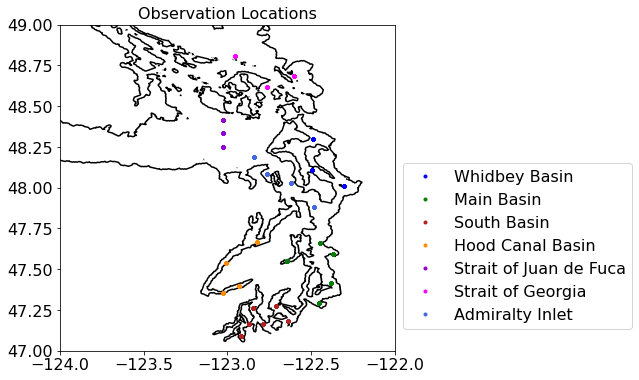

In [50]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

In [51]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion] 
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
#Adding extra columns to assist in chlorophyll analysis.

Chl_to_N=1.8
data_Pheo['log_Chl']=ket.logt(data_Pheo['Chla_Lab'])
data_Pheo['log_mod_diatoms']=ket.logt(data_Pheo['mod_diatoms']*Chl_to_N)
data_Pheo['log_mod_ciliates']=ket.logt(data_Pheo['mod_ciliates']*Chl_to_N)
data_Pheo['log_mod_flagellates']=ket.logt(data_Pheo['mod_flagellates']*Chl_to_N)
data_Pheo['mod_Chl']=((data_Pheo['mod_diatoms']*Chl_to_N)+(data_Pheo['mod_ciliates']*Chl_to_N)+(data_Pheo['mod_flagellates']*Chl_to_N))
data_Pheo['log_mod_Chl']=ket.logt((data_Pheo['mod_diatoms']*Chl_to_N)+(data_Pheo['mod_ciliates']*Chl_to_N)+(data_Pheo['mod_flagellates']*Chl_to_N))

# defning a dictionary that brakes the data down by individual stations
datstat_Pheo=dict()
for ind, istation in enumerate(data_Pheo.Station.unique()):
    datstat_Pheo[istation]=data_Pheo.loc[data_Pheo.Station == istation]

datreg_Pheo=dict()
for iregion in data_Pheo.Basin.unique():
    datreg_Pheo[iregion] = data_Pheo.loc[data_Pheo.Basin==iregion] 
    
datyear_Pheo=dict()
for iyear in data_Pheo.dtUTC.dt.year.unique():
    datyear_Pheo[iyear] = data_Pheo.loc[data_Pheo.dtUTC.dt.year==iyear]


# Nitrate
## Observed nitrate and model nitrate over time with depth

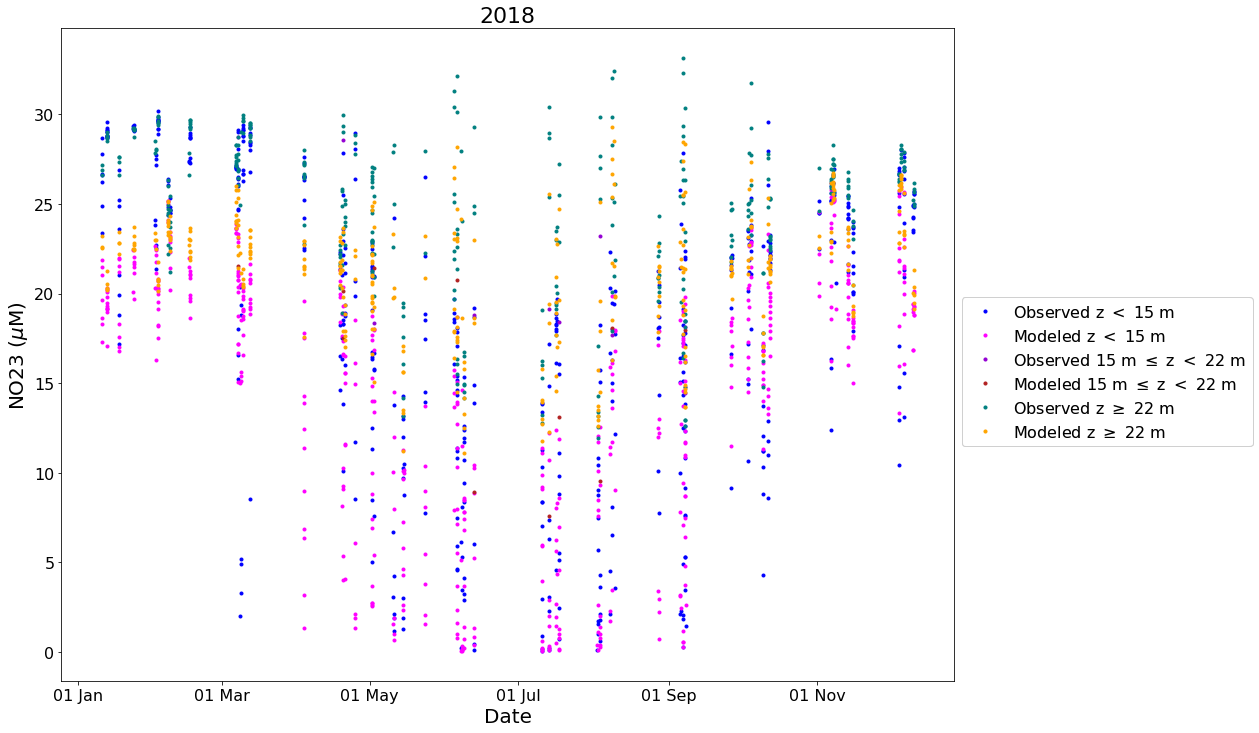

In [52]:
obsvar='NO23'
modvar='mod_nitrate'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12))

## Observed nitrate and model nitrate over time for different regions

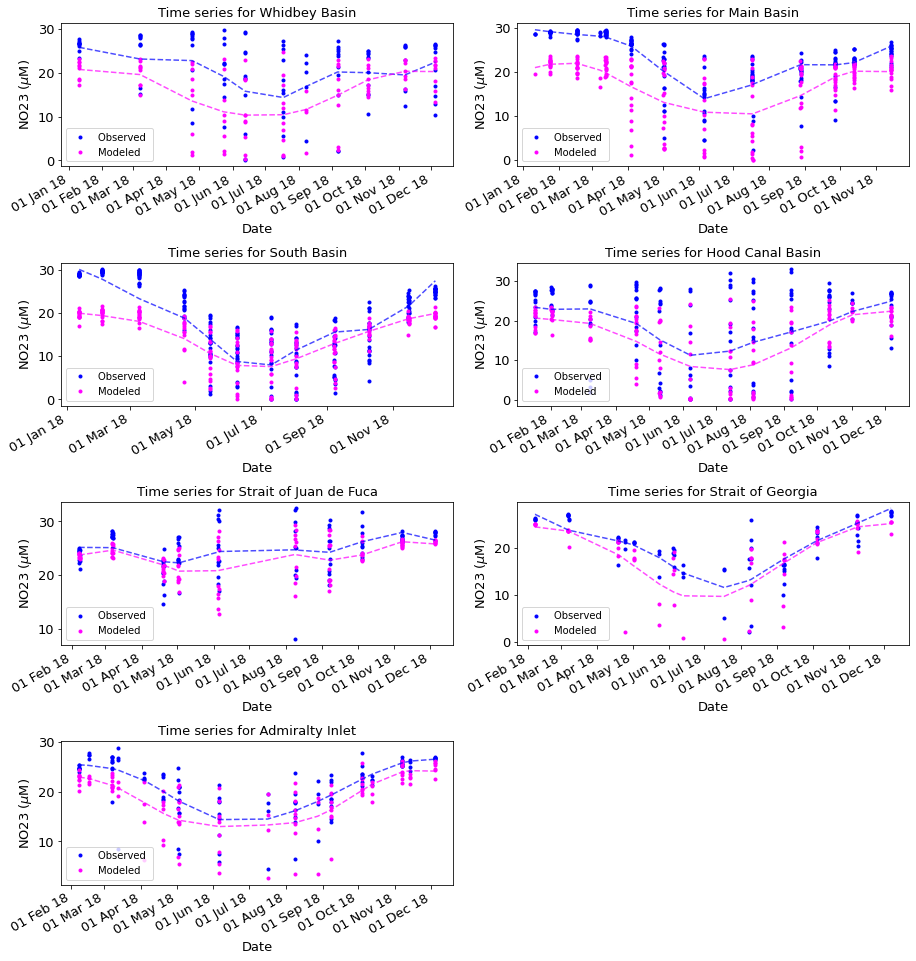

In [53]:
ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,trendline=True)

## Observed nitrate and model nitrate over time individual depths

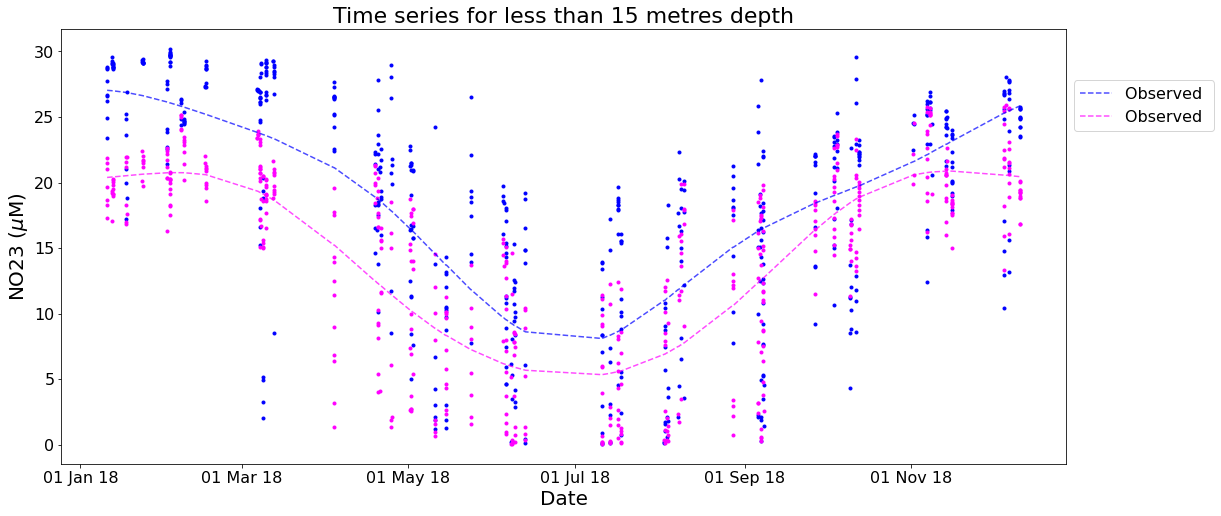

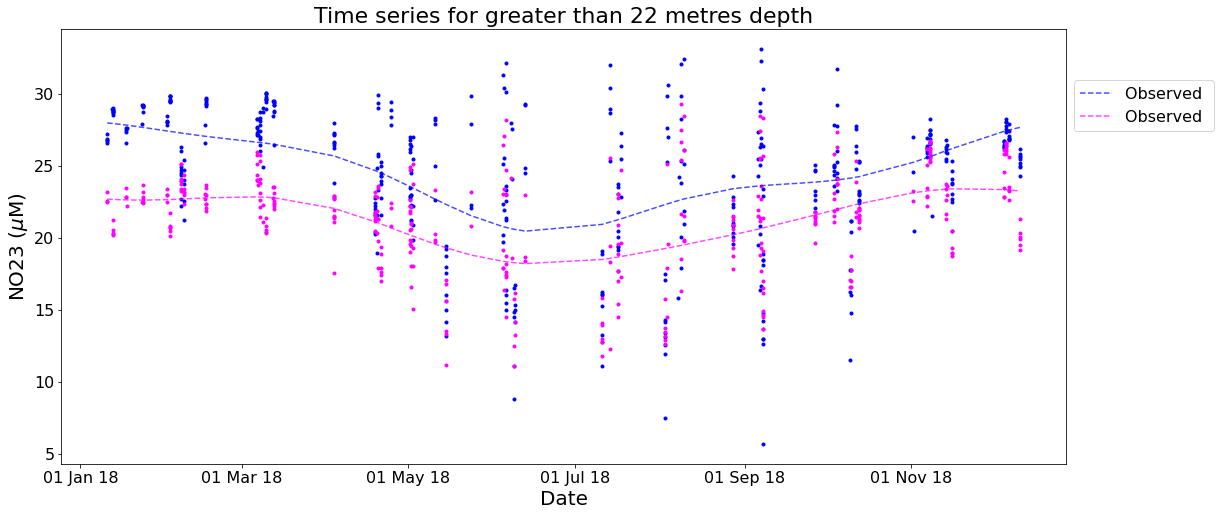

In [54]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data[data.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

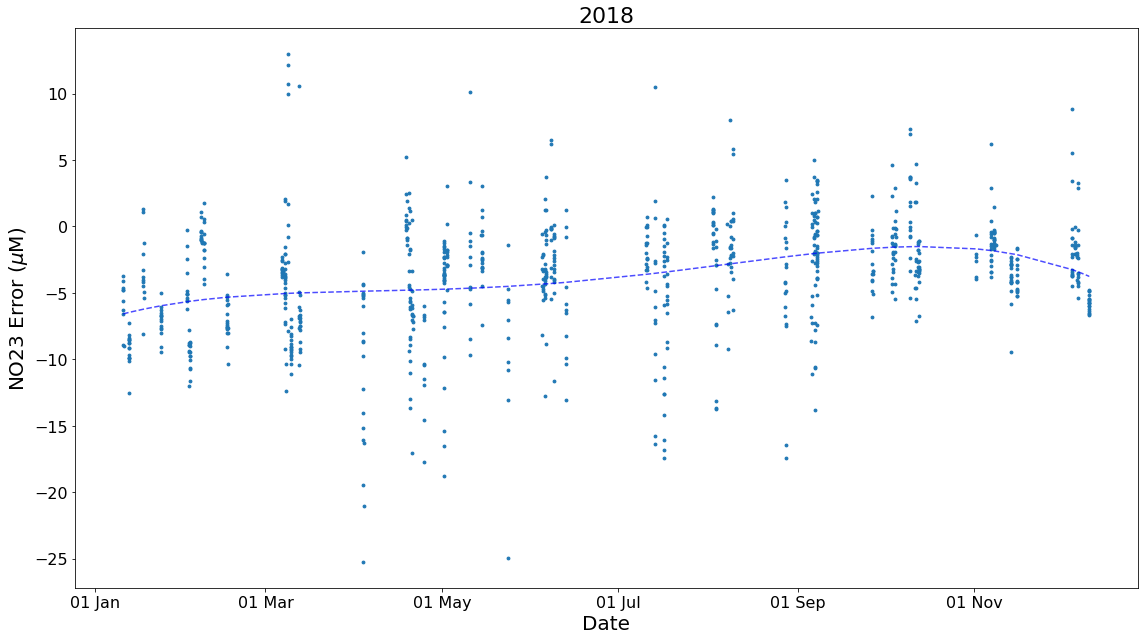

In [55]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data,obsvar,modvar,start_date,end_date)

# Silicon
## Observed Silicon and model Silicon over time with depth

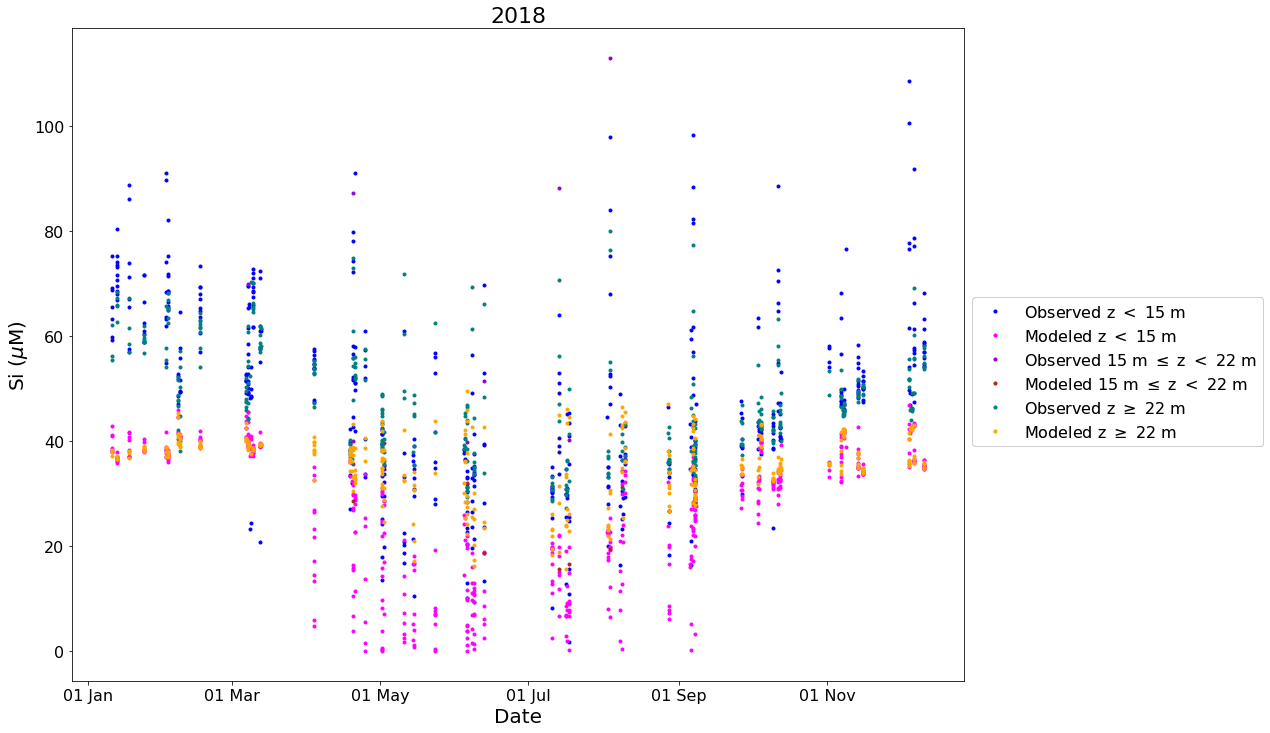

In [56]:
obsvar='Si'
modvar='mod_silicon'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12))

## Observed Silicon and model Silicon over time for different regions

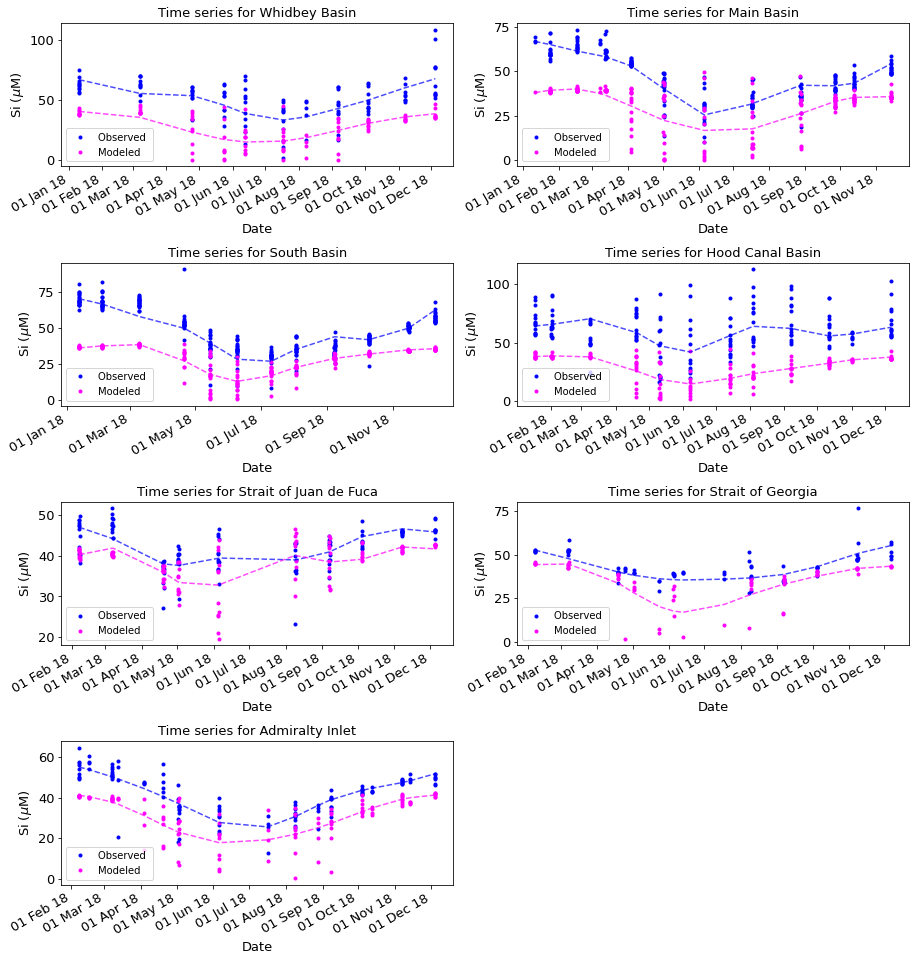

In [57]:
ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,trendline=True)

## Observed Silicon and model Silicon over time individual depths

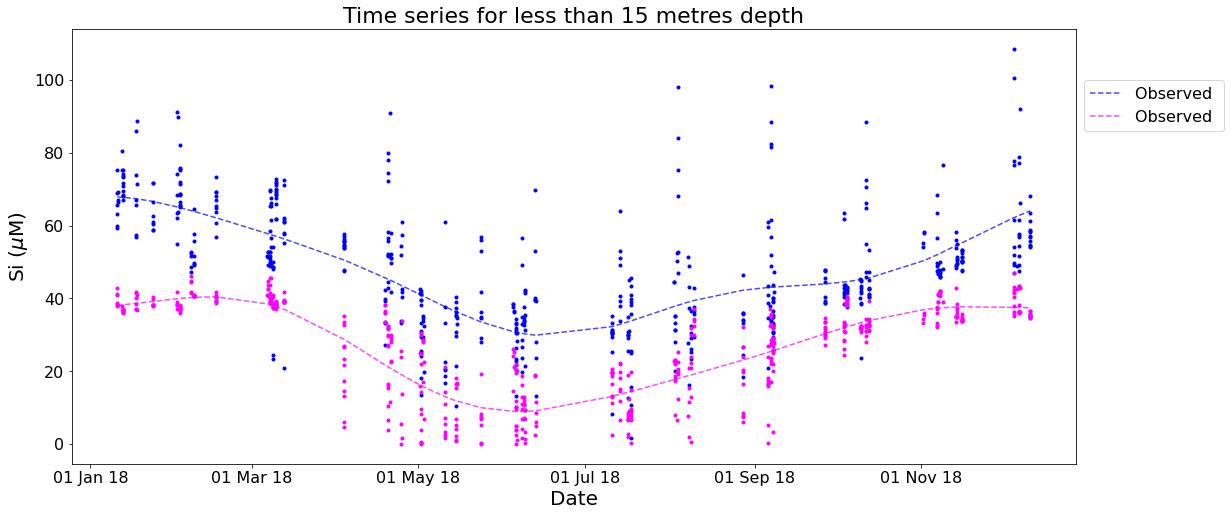

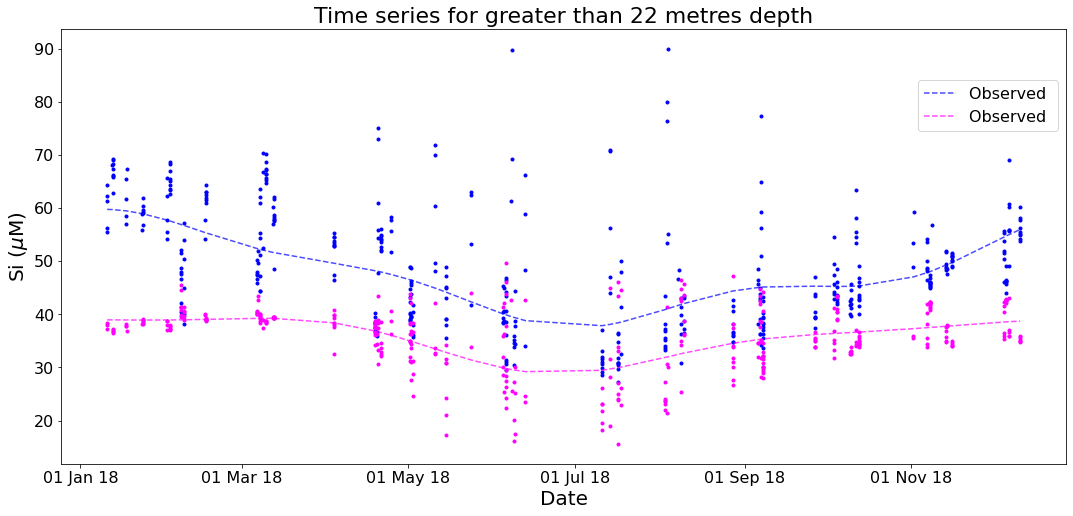

In [58]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data[data.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

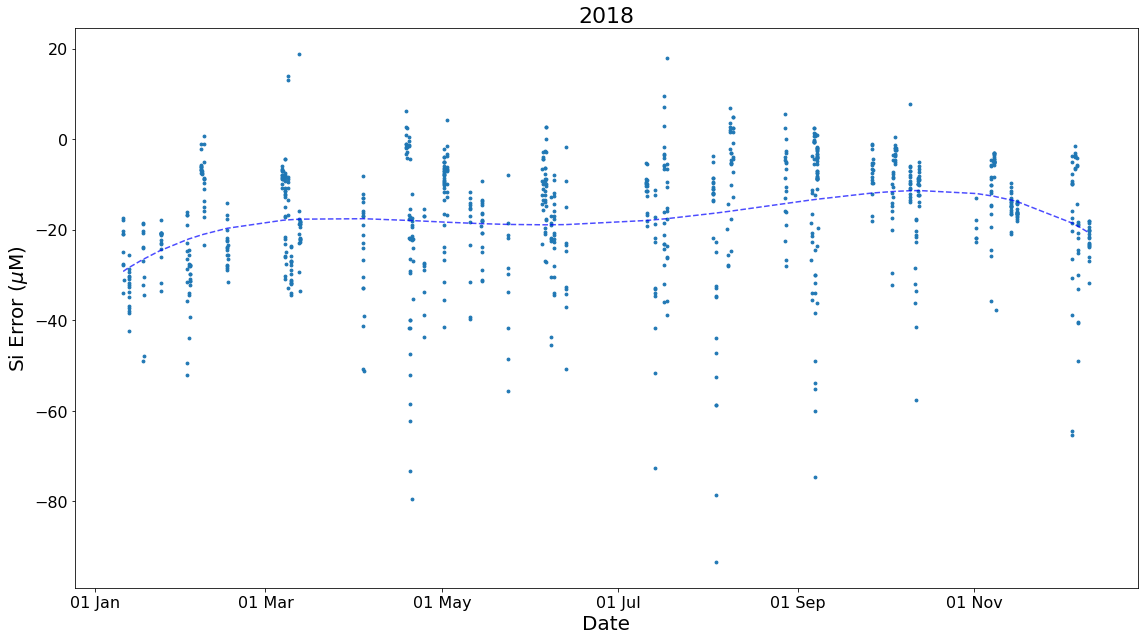

In [59]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data,obsvar,modvar,start_date,end_date)

# Ammonium

## Observed Ammonium and model Ammonium over time by 

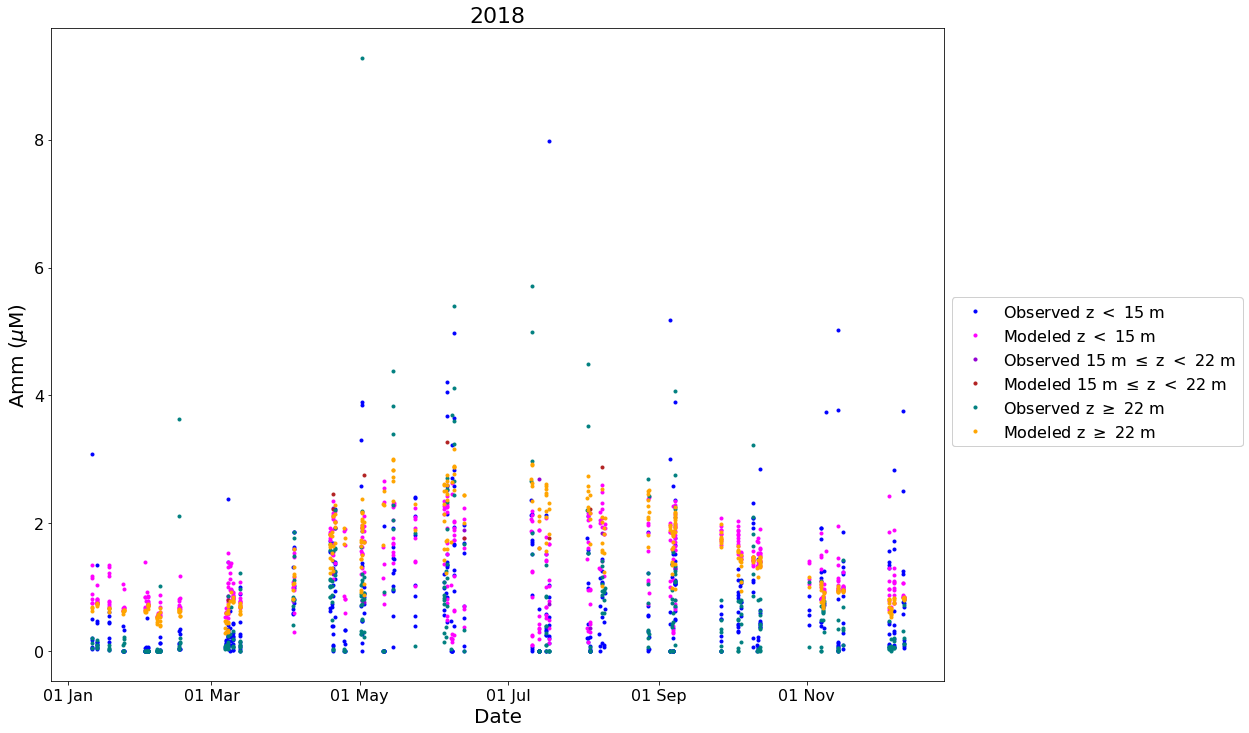

In [60]:
obsvar='Amm'
modvar='mod_ammonium'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12))

## Observed Ammonium and model Ammonium over time for different regions

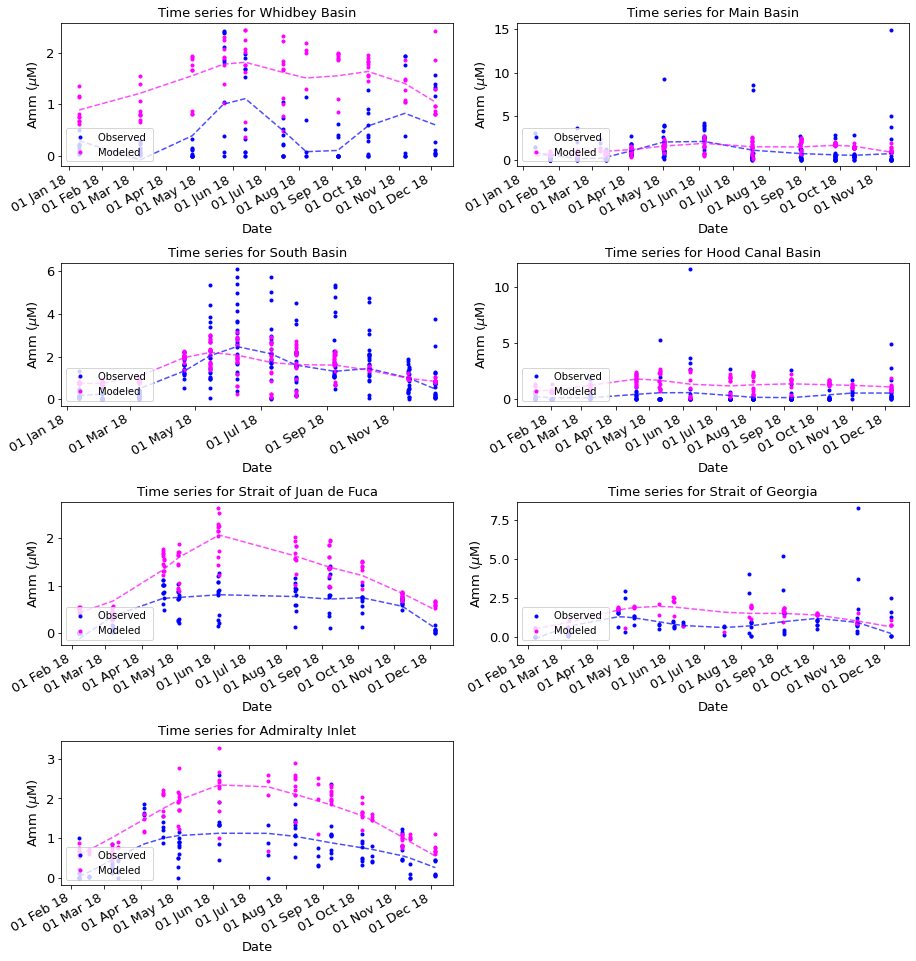

In [61]:
ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,trendline=True)

## Observe Ammonium and model Ammonium over time individual depths

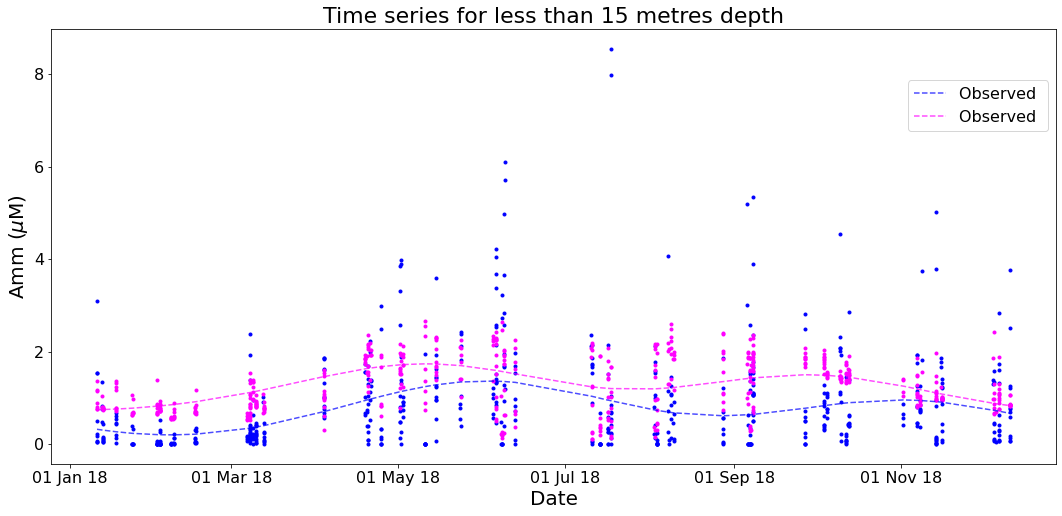

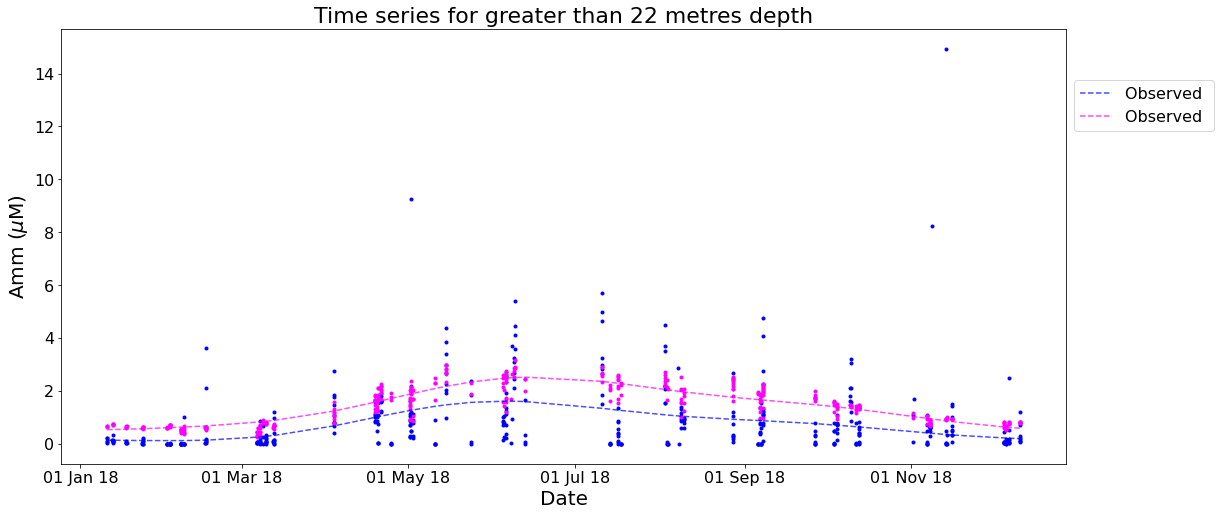

In [62]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[(data.Z < 15)],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data[data.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

# Error vs time of year

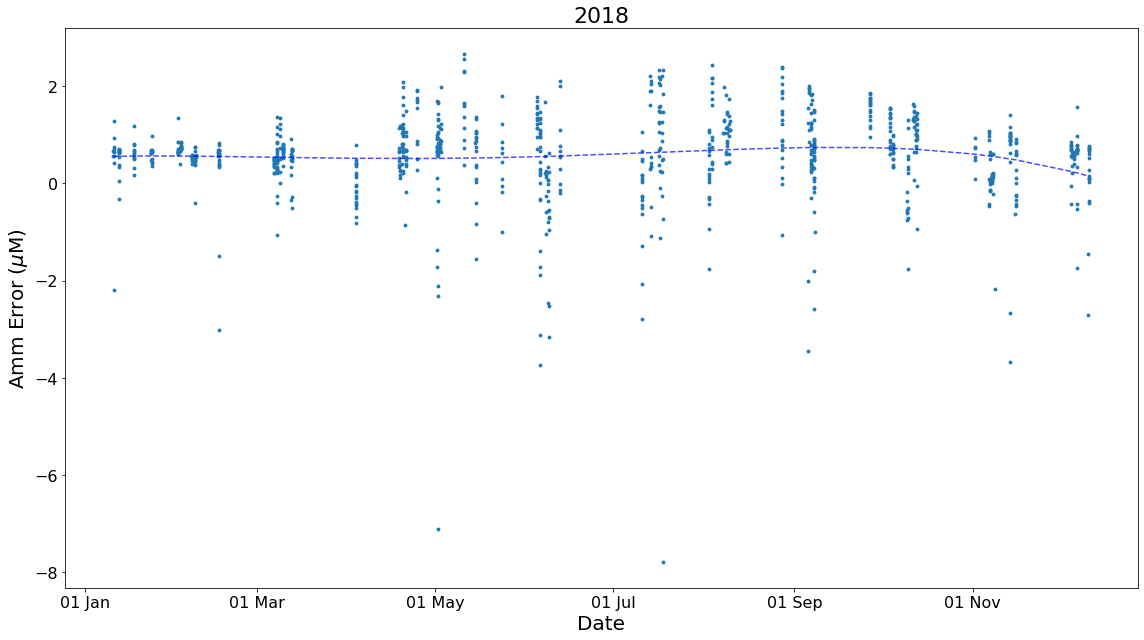

In [63]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data,obsvar,modvar,start_date,end_date)

# Salinity

## Observed Salinity and model Salinity over time 

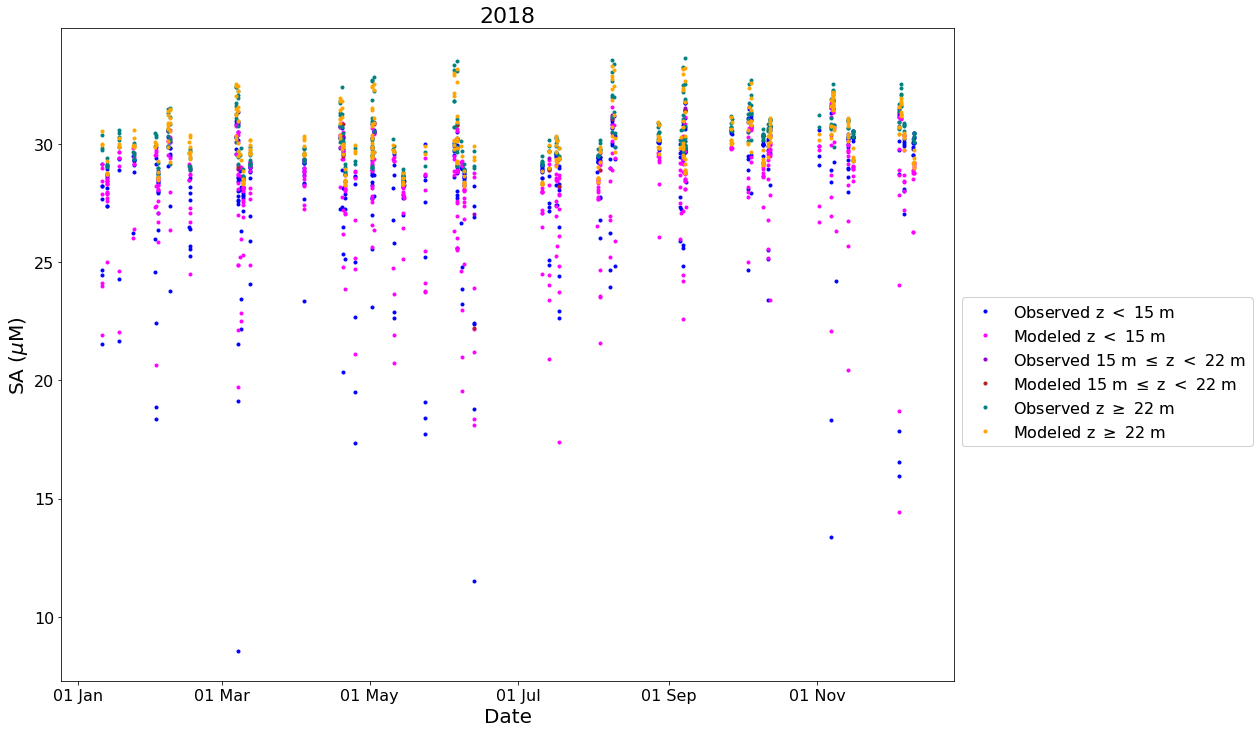

In [64]:
obsvar='SA'
modvar='mod_vosaline'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12))

## Observed Salinity and model Salinity over time for different regions

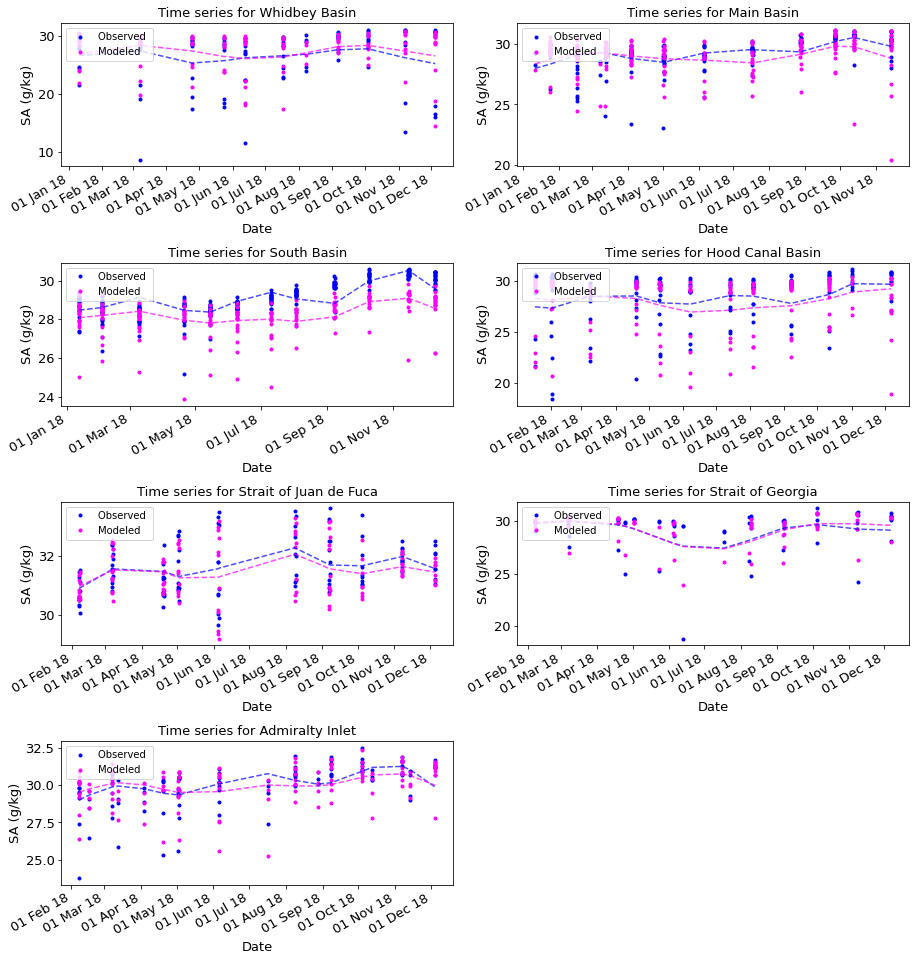

In [65]:
ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,loc='upper left',units='(g/kg)',trendline=True)

## Observe Salinity and model Salinity over time individual depths

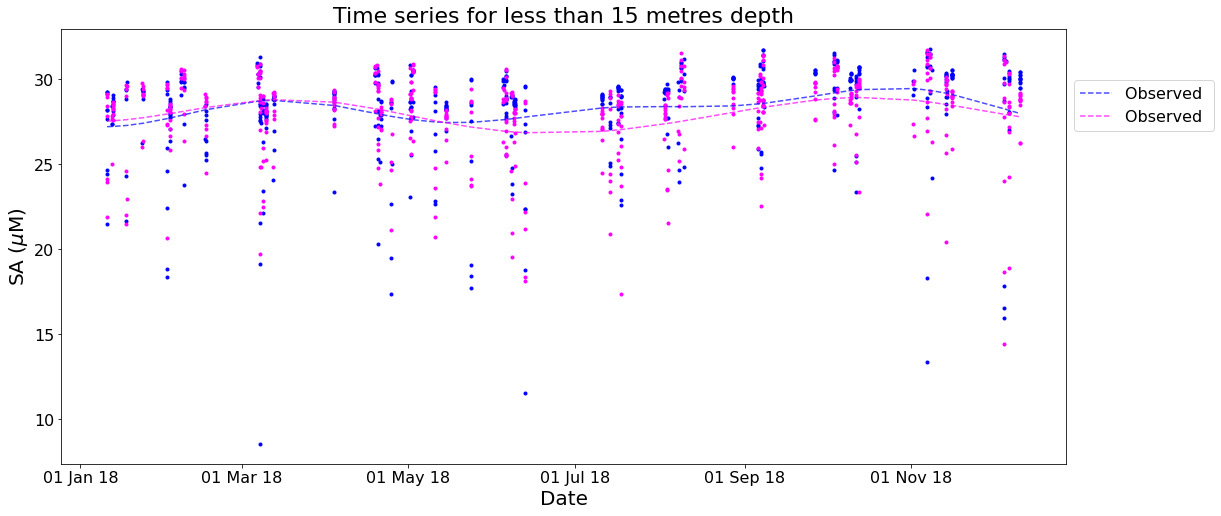

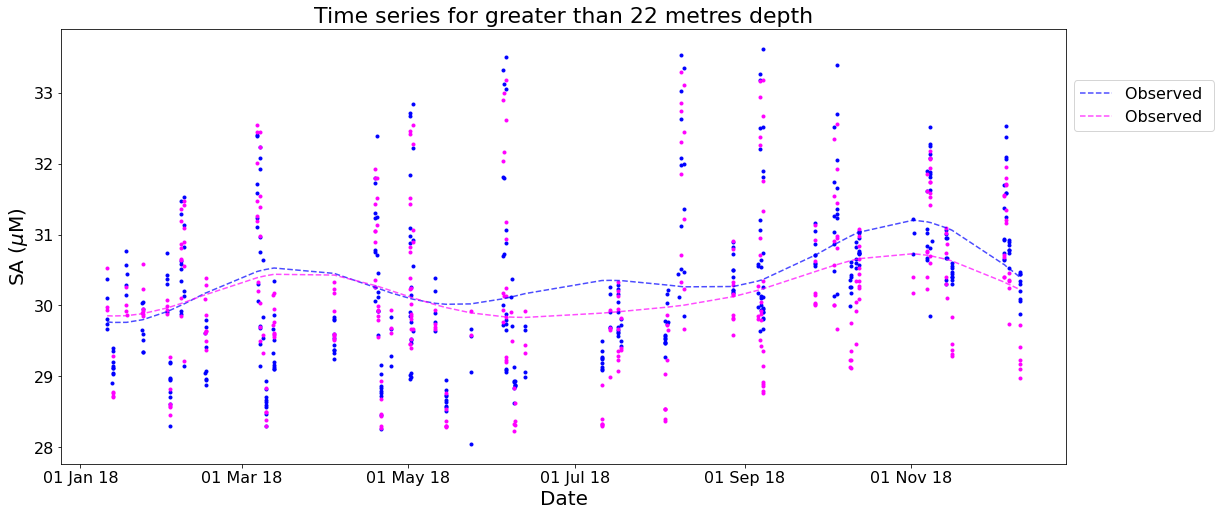

In [66]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data[data.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

# Error vs time of year

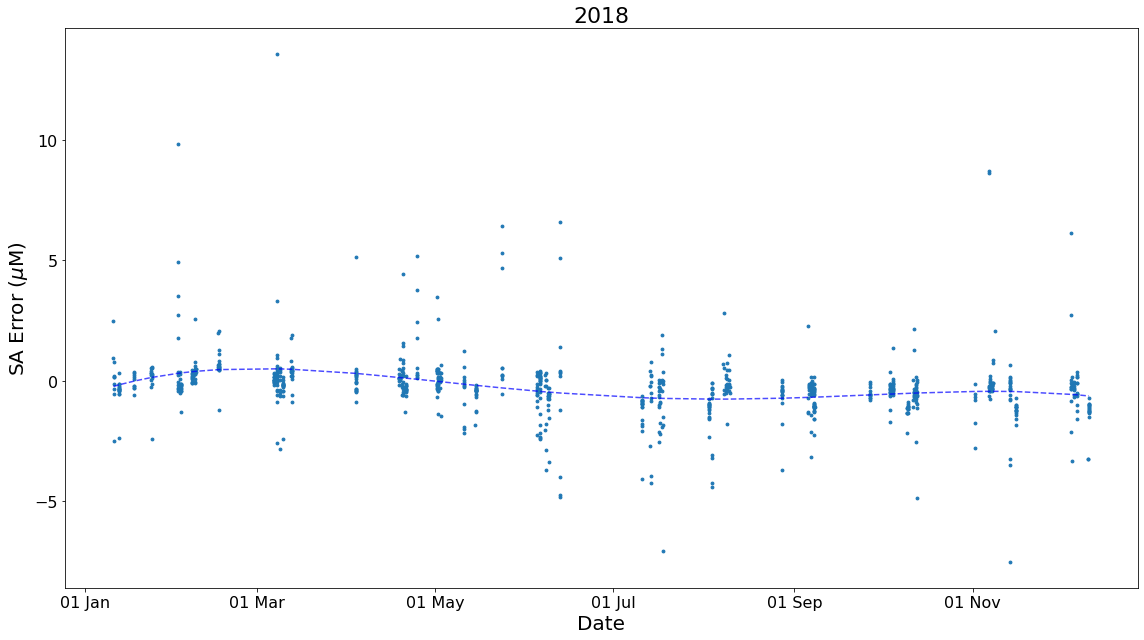

In [67]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data,obsvar,modvar,start_date,end_date)

# Temperature

## Observed Temperature and model Temperature over time 

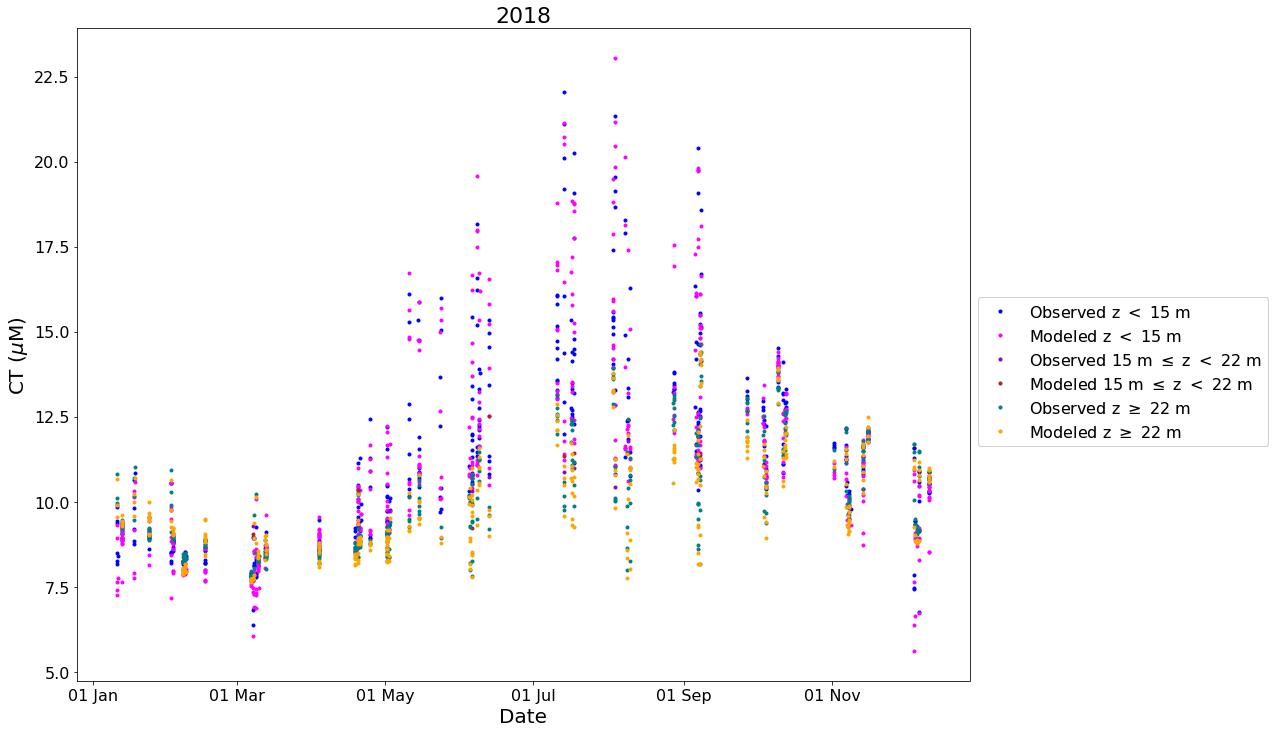

In [68]:
obsvar='CT'
modvar='mod_votemper'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12))

## Observed Temperature and model Temperature over time for different regions

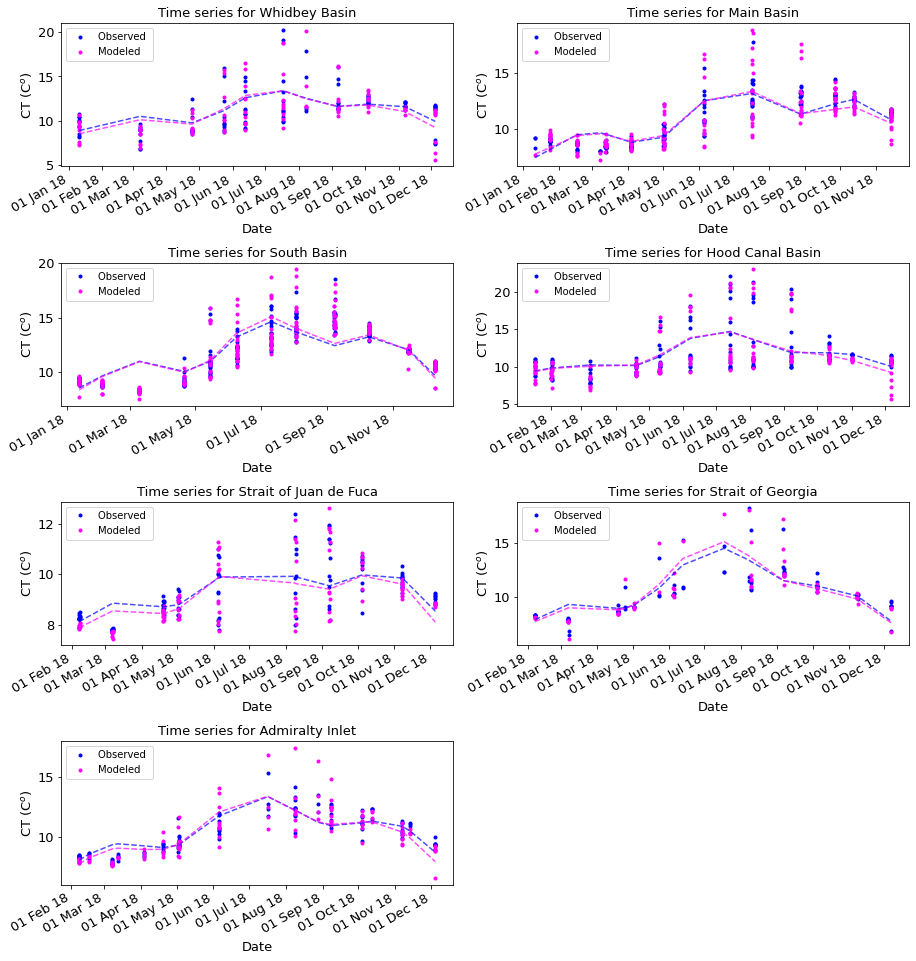

In [69]:
ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,loc='upper left',units='(C$^o$)',trendline=True)

## Observed Temperature and model Temperature over time individual depths

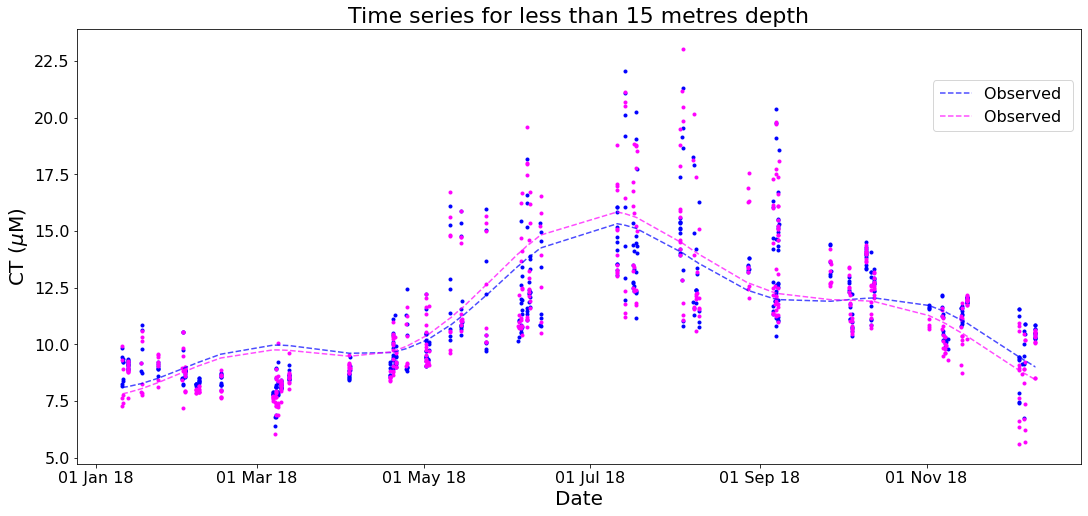

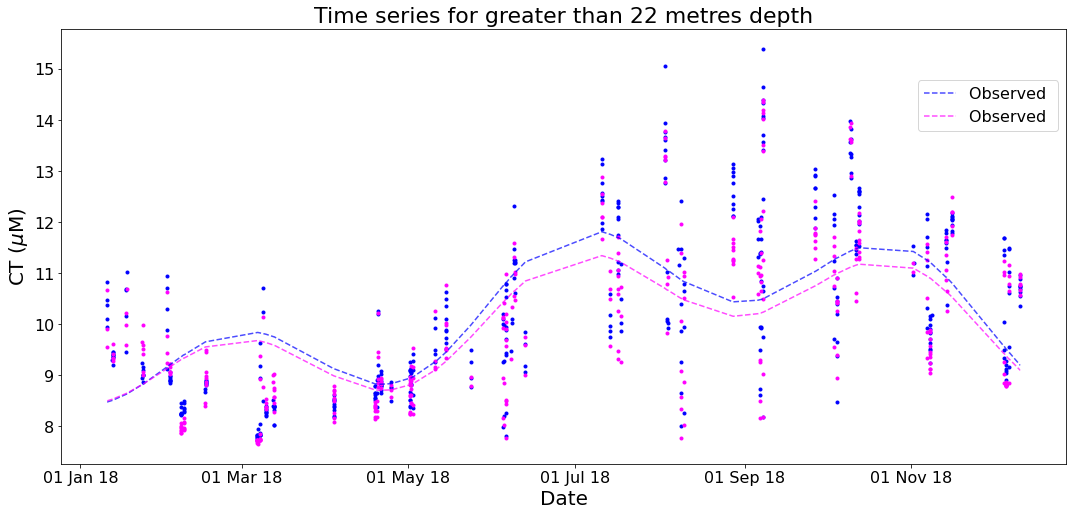

In [70]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[(data.Z < 15)],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data[data.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

# Error vs time of year

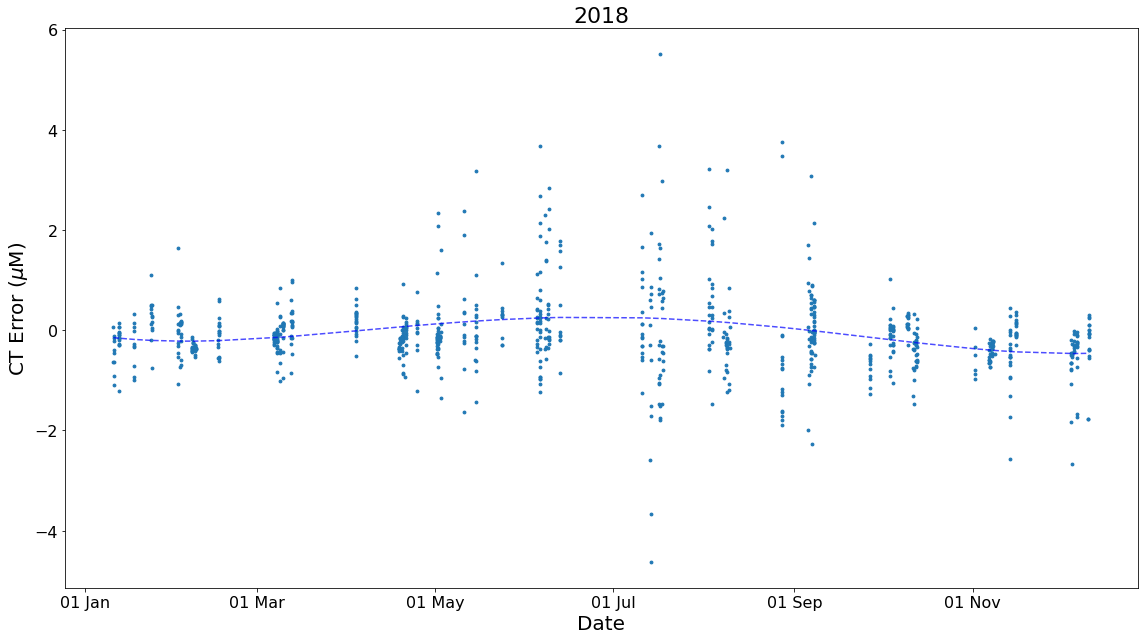

In [71]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data,obsvar,modvar,start_date,end_date)

# Log transformed Chlorophyll
## Observed Chlorophyll and model Chlorophyll over time with depth (log Transformed)

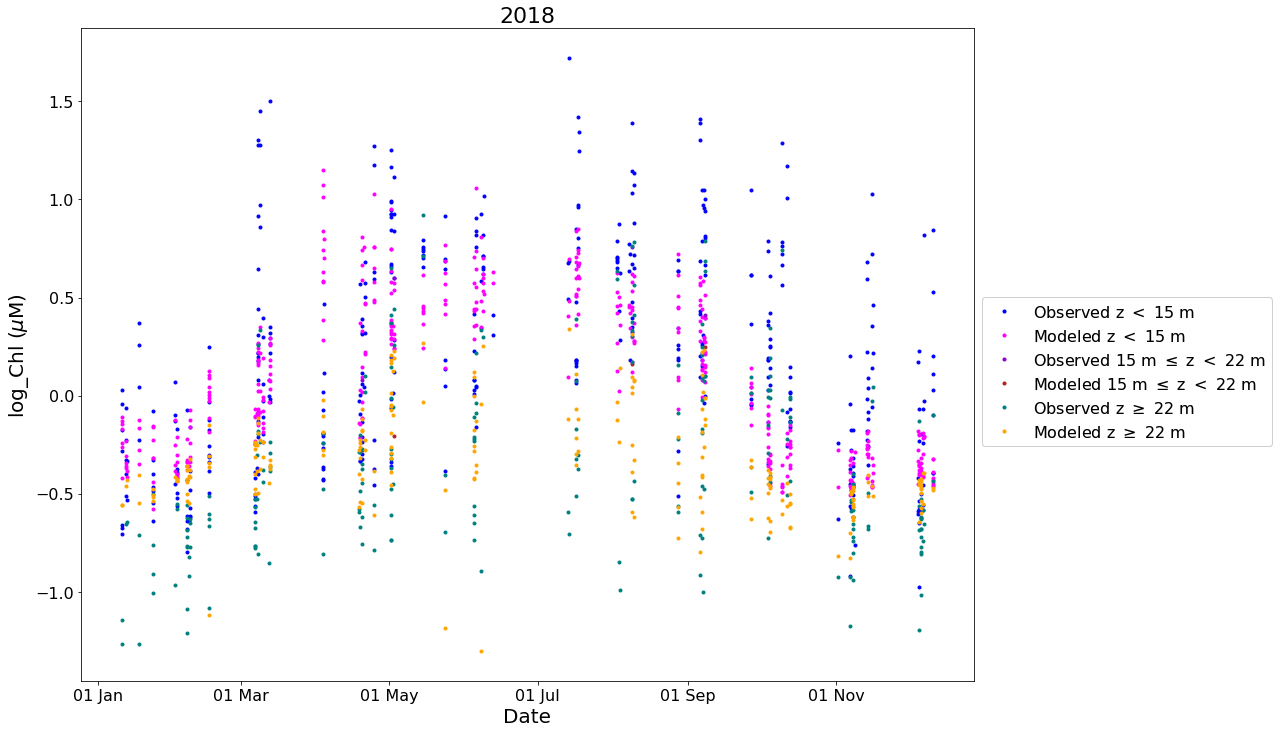

In [72]:
obsvar='log_Chl'
modvar='log_mod_Chl'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data_Pheo,year,obsvar,modvar,(16,12))

## Observed Chlorophyll and model Chlorophyll over time for different regions (Log transformed)

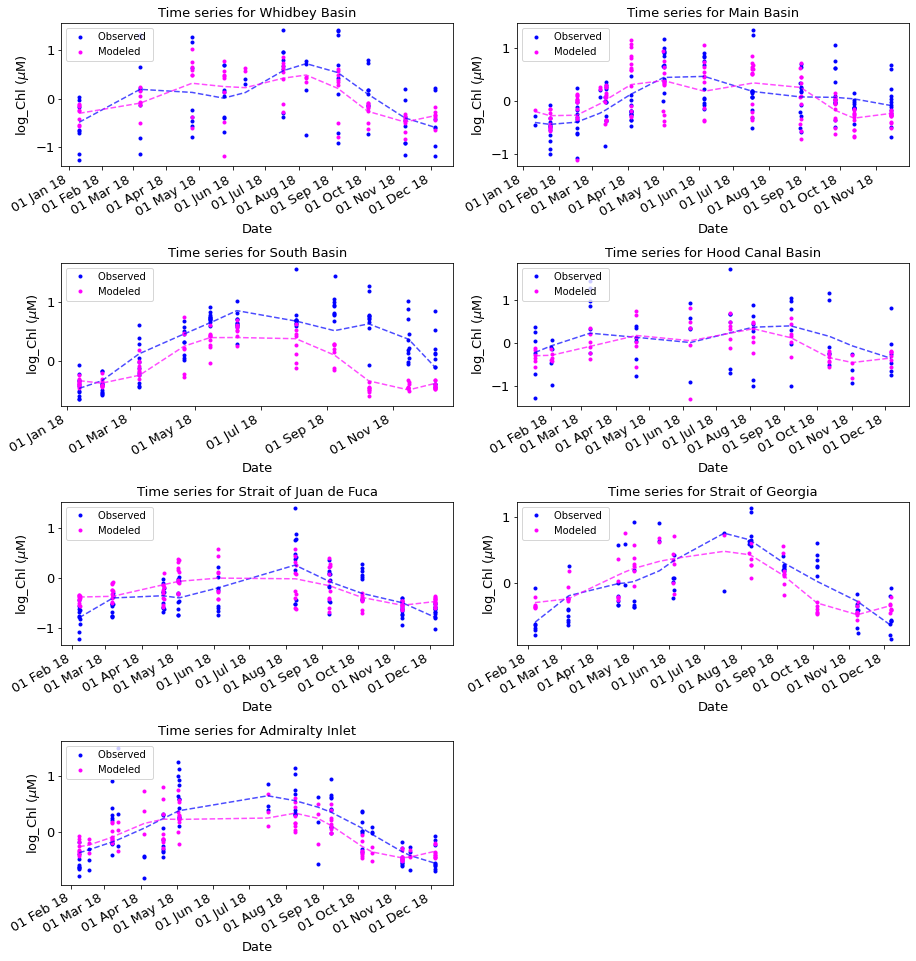

In [73]:
obsvar='log_Chl'
modvar='log_mod_Chl'

ket.TsByRegion(datreg_Pheo,data_Pheo.Basin.unique(),obsvar,modvar,year,loc='upper left',trendline=True)

## Observed Chlorophyll and model Chlorophyll over time individual depths

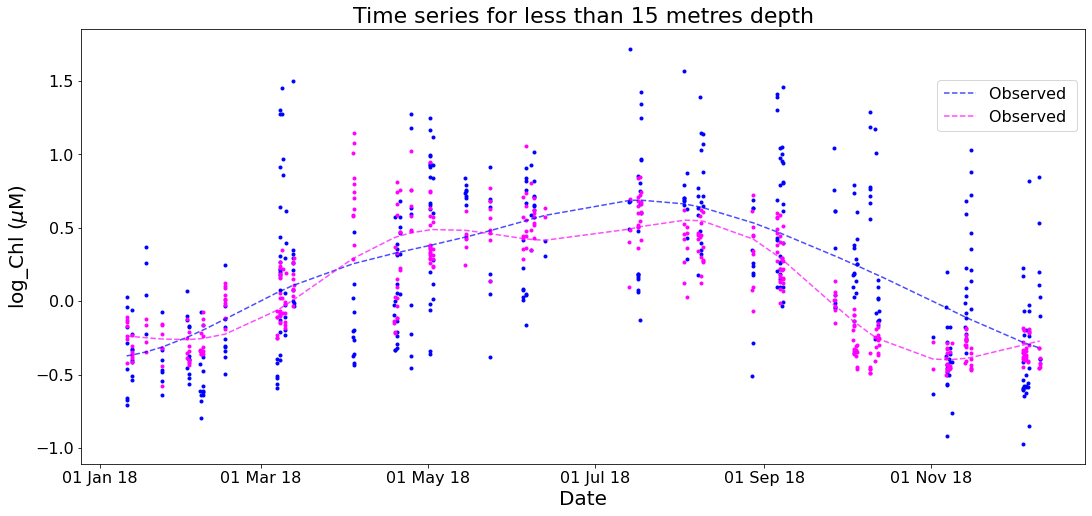

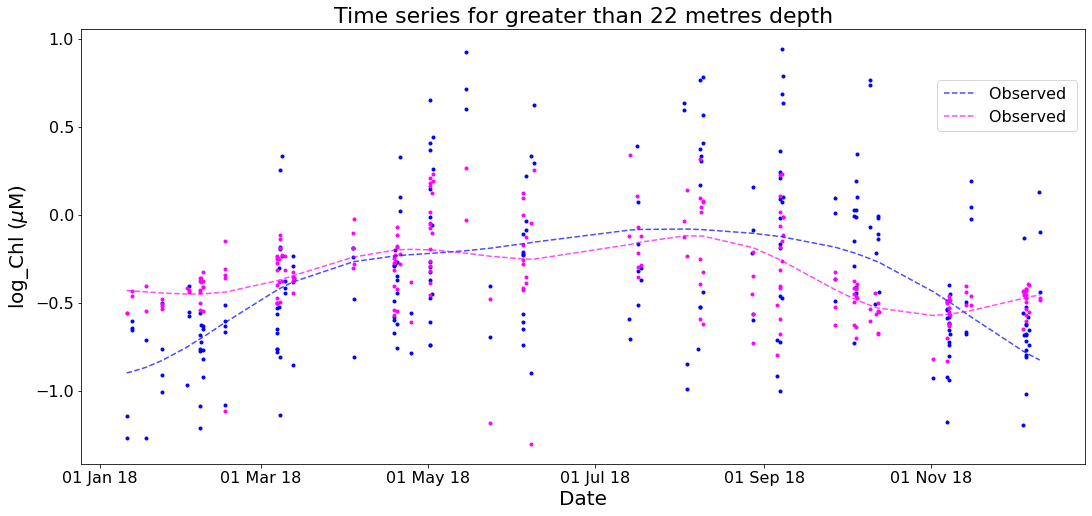

In [74]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data_Pheo[data_Pheo.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data_Pheo[data_Pheo.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

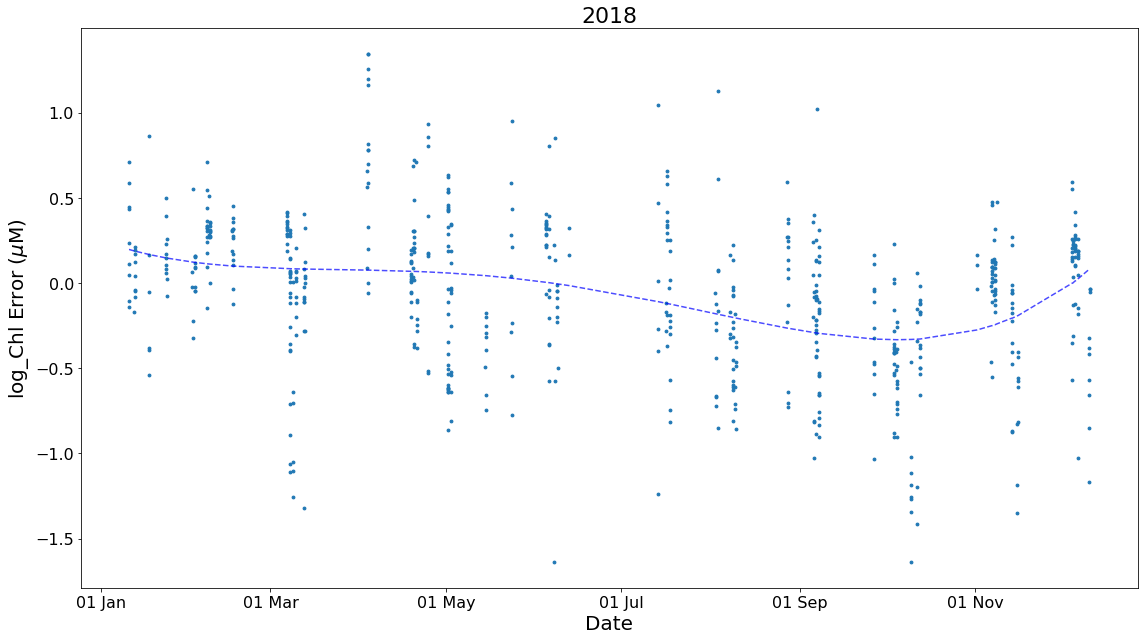

In [75]:
ax=ket.multi_timerror_graph(data_Pheo,datyear_Pheo,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data_Pheo,obsvar,modvar,start_date,end_date)

# Untransformed Chlorophyll
## Observed Chlorophyll and model Chlorophyll over time with depth

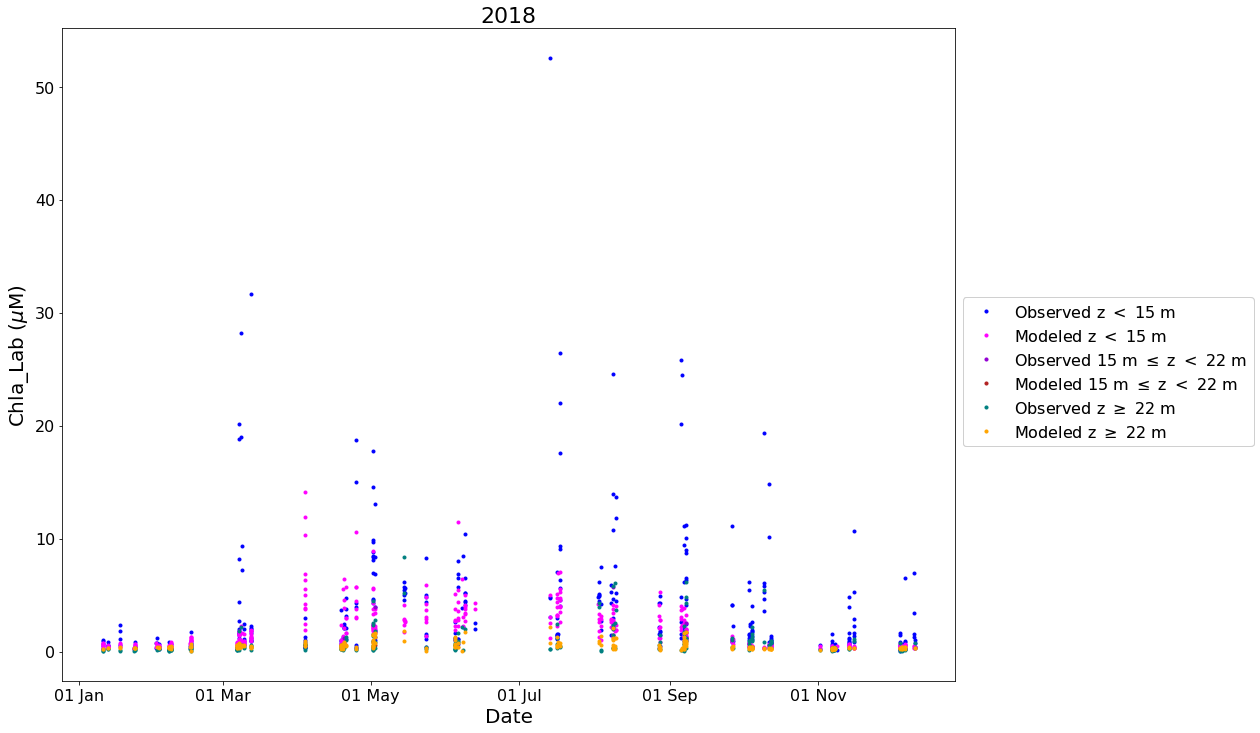

In [76]:
obsvar='Chla_Lab'
modvar='mod_Chl'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data_Pheo,year,obsvar,modvar,(16,12))

## Observed Chlorophyll and model Chlorophyll over time for different regions

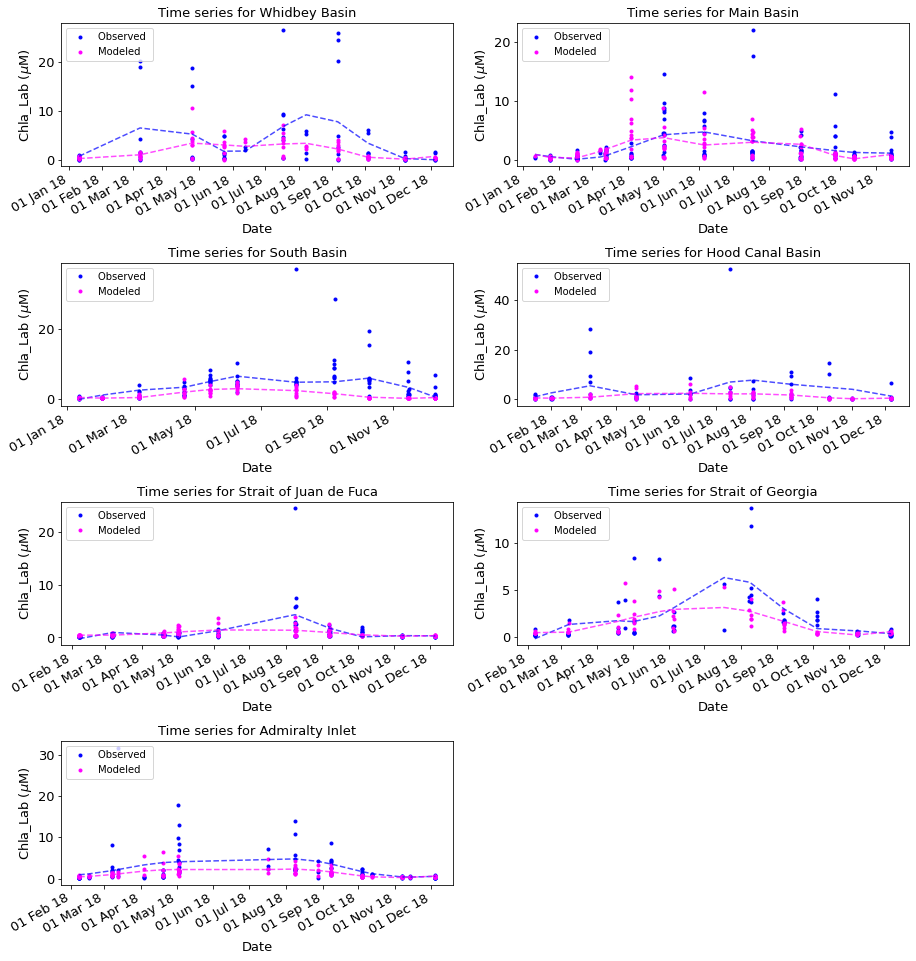

In [77]:
ket.TsByRegion(datreg_Pheo,data_Pheo.Basin.unique(),obsvar,modvar,year,loc='upper left',trendline=True)

## Observed Chlorophyll and model Chlorophyll over time individual depths

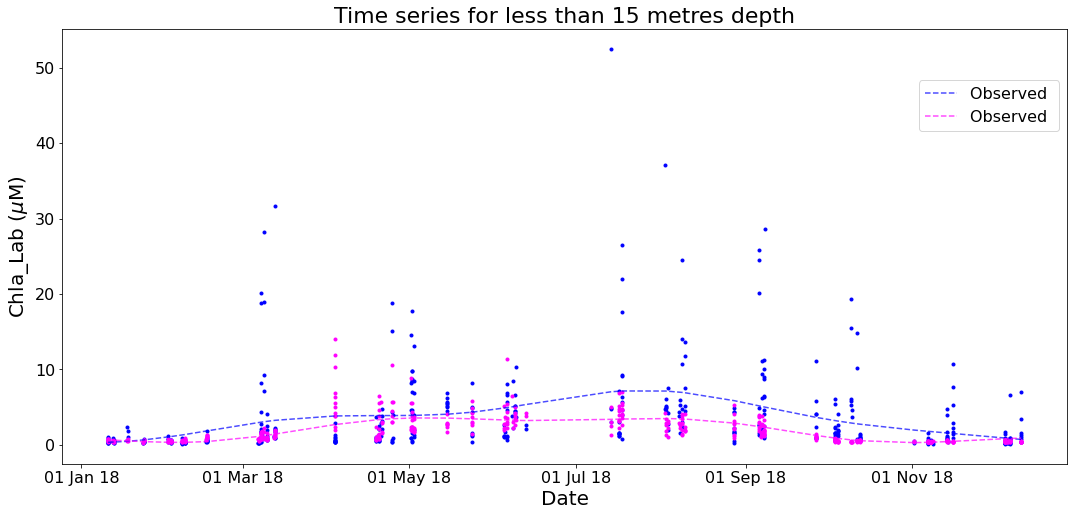

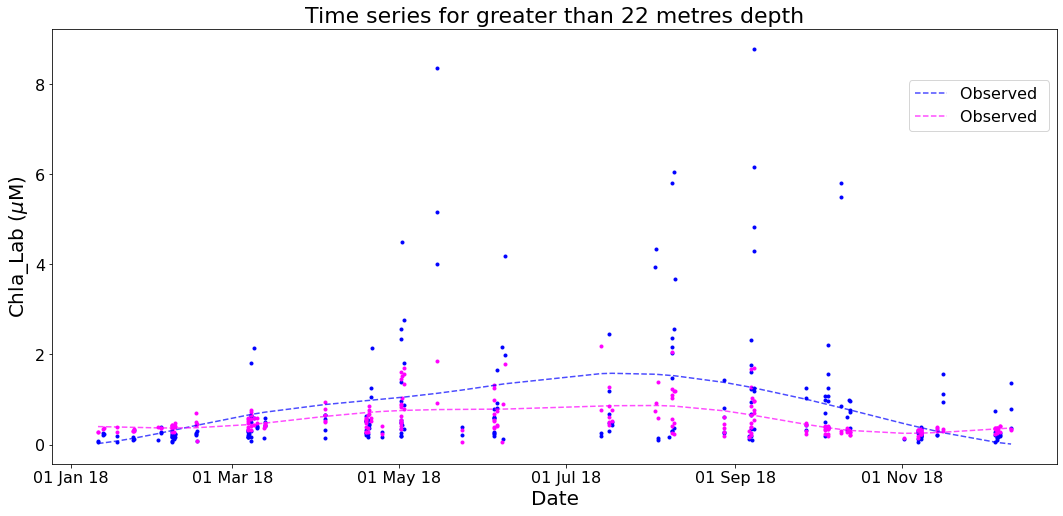

In [78]:
title='Time series for less than 15 metres depth'
ax=TsByDepth(data_Pheo[data_Pheo.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 22 metres depth'
ax=TsByDepth(data_Pheo[data_Pheo.Z > 22],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z > 22],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

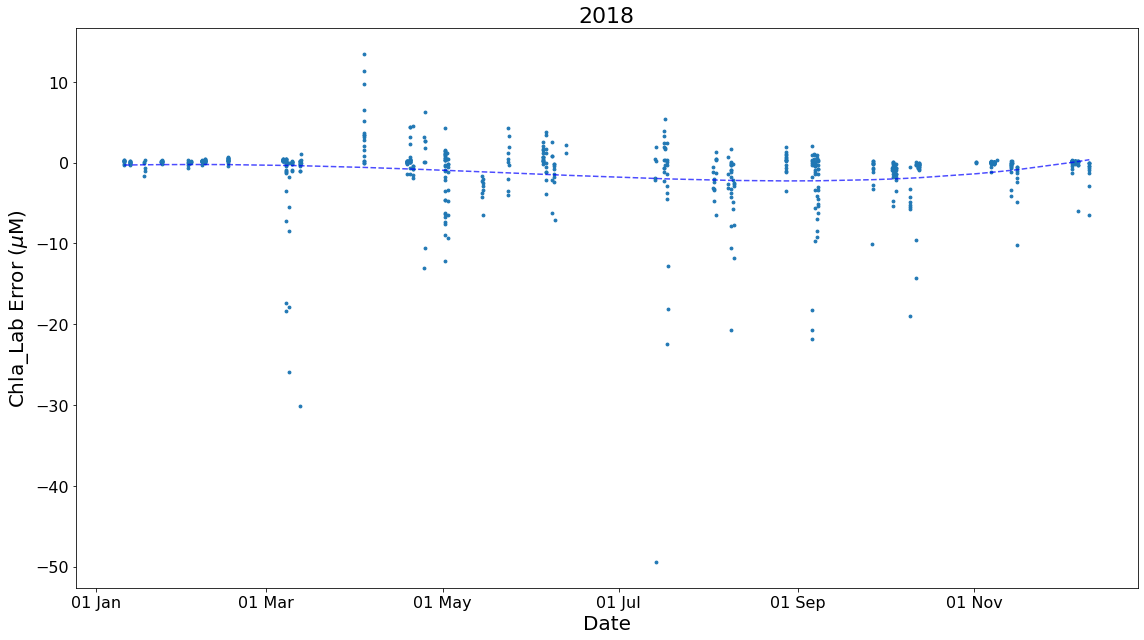

In [80]:
ax=ket.multi_timerror_graph(data_Pheo,datyear_Pheo,year,obsvar,modvar,(16,9))
ps=ts_error_trendline(ax,data_Pheo,obsvar,modvar,start_date,end_date)